In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
sns.set_theme(style="ticks", palette="deep")

from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import ruamel.yaml as yaml
import torch
import scipy.stats as stats

from soul_gan.datasets.utils import get_dataset, prepare_2d_gaussian_grid_data, prepare_2d_ring_data

from soul_gan.utils.general_utils import DotConfig, CONFIGS_DIR, DATA_DIR
from soul_gan.models.utils import GANWrapper

In [2]:
config = DotConfig(yaml.round_trip_load(Path(CONFIGS_DIR, 'gan_configs/ring-mlp.yml').open('r'))).gan_config

mean = np.array(config.train_transform.Normalize.mean)
std = np.array(config.train_transform.Normalize.std)

In [3]:
sigma = 0.02
n_modes = 8
rad = 2
sample, modes = prepare_2d_ring_data(int(5e3), sigma=sigma, n_modes=n_modes, rad=rad)
#modes = modes[:1]
dists = np.linalg.norm(modes[:, None] - modes[None, :], ord=2, axis=-1)
dists += dists.max() * np.eye(dists.shape[0])
eps = dists.min(-1)

np.savez(
    Path(DATA_DIR, f'{n_modes}_gaussians_modes.npz').open('wb'), 
    centroids=(modes - mean[None, :]) / std[None, :], 
    closest_pts=(modes - mean[None, :]) / std[None, :], 
    sigmas=np.ones(len(modes))*sigma / std[0],
    priors=np.ones(len(modes)) / len(modes),
    eps=eps,
)


In [4]:
kind = 'ring'

dataset = get_dataset(f"gaussians_{kind}", int(5e3))
dataset[0]

tensor([2.0358, 0.0135])

In [5]:
def plot(target, feature, step_size, suffix='', step=1000):
    path = Path(f'../log/{feature}_{target}Target/mlp_{kind}{suffix}_{step_size}')
    xs = np.load(Path(path, f'images/{step}.npy'))

    plt.figure(figsize=(5, 5))
    plt.scatter(xs[:, 0], xs[:, 1], alpha=0.1, s=10)

    plt.scatter(modes[:, 0], modes[:, 1], color='r', marker='x')
    plt.axis('equal')
    plt.grid()

    Path(path, 'figs').mkdir(exist_ok=True)
    plt.savefig(Path(path, f'figs/{kind}{suffix}_{step_size}_2d_{step}.png'))

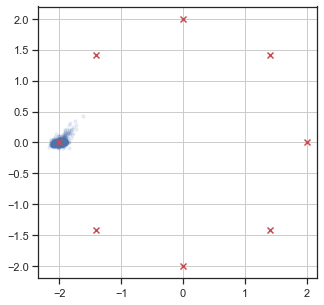

In [6]:
step_size = 0.001
target = 'Discriminator'
feature = 'dumb_feature'

plot(target, feature, step_size, step=0)

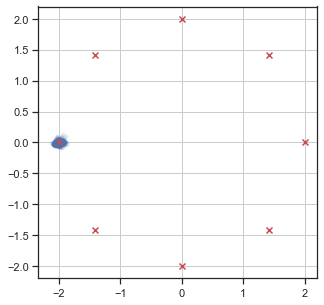

In [7]:
step_size = 0.001
target = 'Discriminator'
feature = 'dumb_feature'

plot(target, feature, step_size)

In [8]:
# step_size = 0.1
# target = 'Discriminator'
# feature = 'cluster_feature'

# plot(target, feature, step_size, suffix='_v1')

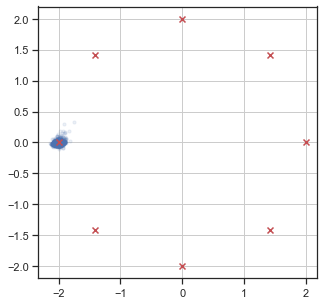

In [9]:
step_size = 0.01
target = 'Discriminator'
feature = 'cluster_feature'

plot(target, feature, step_size)

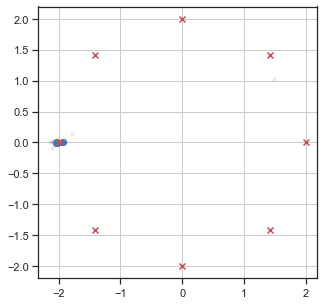

In [32]:
step_size = 0.001

target = 'Discriminator'
feature = 'discriminator_feature'

plot(target, feature, step_size)

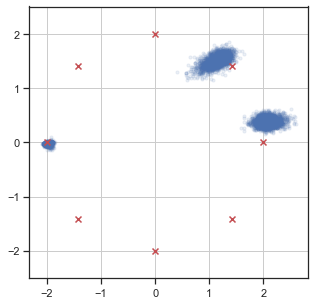

In [33]:
step_size = 0.01
target = 'Discriminator'
feature = 'cluster_feature'

plot(target, feature, step_size, suffix='_v1')


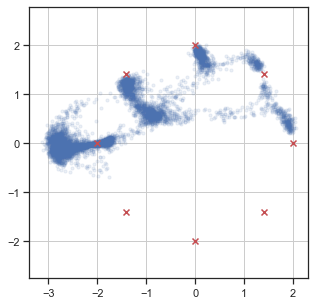

In [34]:
step_size = 0.001
target = 'Discriminator'
feature = 'cluster_feature'

plot(target, feature, step_size, suffix='_v2')


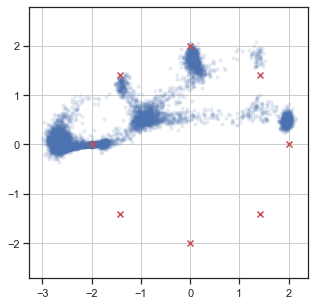

In [35]:
step_size = 0.001
target = 'Discriminator'
feature = 'cluster_feature'

plot(target, feature, step_size, suffix='_v3', step=1000)

In [14]:
device = torch.device(0)

config = DotConfig(yaml.round_trip_load(Path(CONFIGS_DIR, 'gan_configs/ring-mlp.yml').open('r'))).gan_config
gan = GANWrapper(config, device)
gen = gan.gen
dis = gan.dis

In [15]:
n_pts_ax = 100
n_kde_pts = 50000
latent_grid = np.meshgrid(np.linspace(-3, 3, n_pts_ax), np.linspace(-3, 3, n_pts_ax))
real_grid = np.meshgrid(np.linspace(-5, 5, n_pts_ax), np.linspace(-5, 5, n_pts_ax))

zs = gen.prior.sample((n_kde_pts,))
xs_normalized = gen(zs)
xs = gen.inverse_transform(xs_normalized).detach().cpu().numpy()
dgz = dis(xs_normalized).squeeze().detach().cpu().numpy()

reals = torch.from_numpy(np.stack(real_grid, -1).reshape(-1, 2)).to(device).float()
dgz_ = dis(dis.transform(reals)).squeeze()

reals_np = reals.detach().cpu().numpy()

In [16]:
dgz_.mean(), dgz.mean()

(tensor(-35.8799, device='cuda:0', grad_fn=<MeanBackward0>), -1.7607247)

In [17]:
kde = stats.kde.gaussian_kde(xs.transpose(1, 0))
log_probs = kde.logpdf(reals_np.transpose(1, 0))

Text(0.5, 1.0, '$-\\hat{E}(x) = \\log p_G(x) + d(x)$')

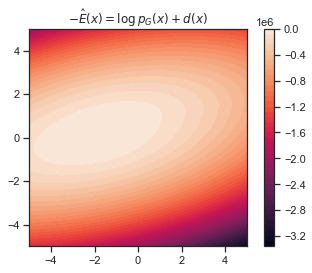

In [18]:
energy = (log_probs + dgz_.detach().cpu().numpy())
energy_grid = energy.reshape(n_pts_ax, n_pts_ax)
#Path('../figs/100gaussians').mkdir(exist_ok=True)

xs_grid = reals_np.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], energy_grid, levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$-\hat{E}(x) = \log p_G(x) + d(x)$')
#plt.savefig(Path('../figs/100gaussians', 'minus_energy_sigma_0.025.png'))

Text(0.5, 1.0, '$\\log p_G(x)$')

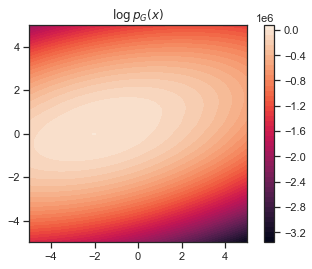

In [19]:
xs_grid = reals_np.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], log_probs.reshape(n_pts_ax, n_pts_ax), levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$\log p_G(x)$')
# plt.savefig(Path('../figs/100gaussians', 'log_prob_0.025.png'))

In [30]:
xs_grid = reals_np.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], dgz_.detach().cpu().numpy().reshape(n_pts_ax, n_pts_ax), levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$d(x)$')
# plt.savefig(Path('../figs/100gaussians', 'dgz_0.025.png'))

NameError: name 'reals_np' is not defined

In [21]:
modes

array([[ 2.00000000e+00,  0.00000000e+00],
       [ 1.41421356e+00,  1.41421356e+00],
       [ 1.22464680e-16,  2.00000000e+00],
       [-1.41421356e+00,  1.41421356e+00],
       [-2.00000000e+00,  2.44929360e-16],
       [-1.41421356e+00, -1.41421356e+00],
       [-3.67394040e-16, -2.00000000e+00],
       [ 1.41421356e+00, -1.41421356e+00]])

In [22]:
mode = torch.as_tensor(modes[-1]).to(device)

loss_f = lambda z: torch.norm(mode[None, :] - gen(z), dim=-1)

xs = []
z = gan.prior.sample((1,)).to(device).requires_grad_(True)
for it in range(1000):
    xs.append(z.detach())
    loss = loss_f(z)
    grad = torch.autograd.grad(loss.sum(0), z)[0]
    z = z - 1 * grad

    if it % 10 == 0:
        print(loss.mean().item()) 


3.685848356081704
3.658517804445308
3.6229611479518122
3.588640078331494
3.5596036608176393
3.5357269429398914
3.5140785525562492
3.494801626795244
3.476190721321121
3.4580899274165398
3.4411954192503913
3.425100521476678
3.4102596627514816
3.3743034227874635
3.3312215309453492
3.2981093080271426
3.2663604995255784
3.2356260279697318
3.207149199765734
3.184573387037939
3.1679912070001155
3.152392464164838
3.1403645500787625
3.129716721968325
3.118991303813942
3.1104023512878682
3.101247141891258
3.0929990871240953
3.0834193393069746
3.0674718755369264
3.0463248791828397
3.027965666023263
2.963672789700663
2.4677705183632566
1.9207865144814191
1.706526823912068
1.6232070963664307
1.5700011756027596
1.5216401889191171
1.4847433540735355
1.449152116471354
1.4145136154149565
1.3798648494872803
1.3468642306845728
1.3134442659170535
1.2816845407902173
1.2508393389815122
1.2235605271023533
1.1990930201310495
1.173824571003209
1.1515343938871905
1.1277245974003312
1.1045051614632575
1.08171702

In [23]:
xs = gen(torch.cat(xs, 0)).detach().cpu().numpy()

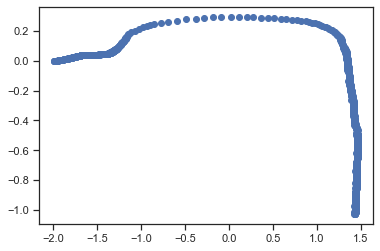

In [24]:
plt.scatter(xs[:, 0], xs[:, 1])